In [2]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.python.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


Labels are:  [0 1]  and the counts are:  [493876 106243]


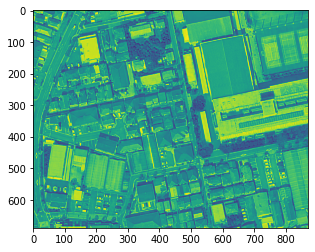

In [7]:
# Quick understanding of the dataset

temp_img = cv2.imread("images/1.jpg") #3 channels / spectral bands
plt.imshow(temp_img[:,:,0]) #View each channel...
temp_mask = cv2.imread("masks/1.png") #3 channels but all same. 
my_mask = np.where(temp_mask>0, 1, temp_mask)
labels, count = np.unique(my_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical

print("Labels are: ", labels, " and the counts are: ", count)


In [8]:
#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 
root_directory = 'C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of different size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    #print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".jpg"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+
                               image_name+"patch_"+str(i)+str(j)+".jpg", single_patch_img)
                    #image_dataset.append(single_patch_img)
            
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dir=root_directory+"masks/"
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".png"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"256_patches/masks/"+
                               mask_name+"patch_"+str(i)+str(j)+".png", single_patch_mask)


Now patchifying image: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/images//1.jpg
Now patchifying image: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/images//2.jpg
Now patchifying image: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/images//3.jpg
Now patchifying mask: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/masks//1.png
Now patchifying mask: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/masks//2.png
Now patchifying mask: C:/Users/goure_zex52ei/Desktop/Research Lab/Thesis/Data-Set/New Program/masks//3.png


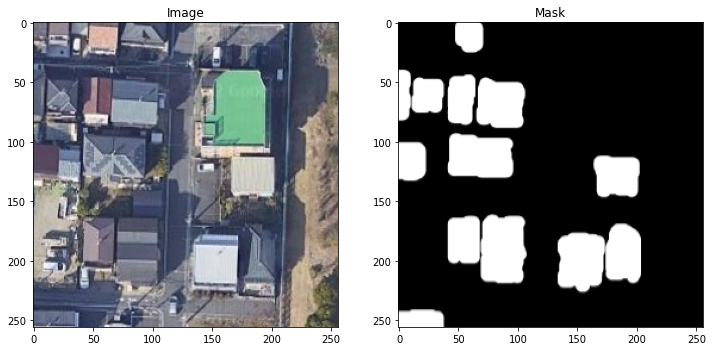

In [11]:
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)
num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [13]:
useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    my_mask = np.where(temp_mask>0, 1, temp_mask)
    #labels, count = np.unique(my_mask[:,:,0], return_counts=True)
    
    val, counts = np.unique(my_mask, return_counts=True)
    print("Labels are: ", val, " and the counts are: ", counts)

    #if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
    #if (1-(val[1]/val.sum())) < 0.5: #At least 1% useful are with labels that are buildings
    for x in val:
        if ((x == 1) and ((counts[1]/counts.sum())>0.05)):
            print(counts[1]/counts.sum())
            print("Save Me")
            cv2.imwrite('256_patches/images_with_useful_info/images/'+img_name, temp_image)
            cv2.imwrite('256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
            break
            
        else:
            print("I am useless")   
            useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

Now preparing image and masks number:  0
Labels are:  [0 1]  and the counts are:  [56516  9020]
I am useless
0.13763427734375
Save Me
Now preparing image and masks number:  1
Labels are:  [0 1]  and the counts are:  [53814 11722]
I am useless
0.178863525390625
Save Me
Now preparing image and masks number:  2
Labels are:  [0]  and the counts are:  [65536]
I am useless
Now preparing image and masks number:  3
Labels are:  [0 1]  and the counts are:  [53966 11570]
I am useless
0.176544189453125
Save Me
Now preparing image and masks number:  4
Labels are:  [0 1]  and the counts are:  [36608 28928]
I am useless
0.44140625
Save Me
Now preparing image and masks number:  5
Labels are:  [0 1]  and the counts are:  [62702  2834]
I am useless
I am useless
Now preparing image and masks number:  6
Labels are:  [0 1]  and the counts are:  [46990 18546]
I am useless
0.282989501953125
Save Me
Now preparing image and masks number:  7
Labels are:  [0]  and the counts are:  [65536]
I am useless
Now prepa

In [14]:
"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = '256_patches/images_with_useful_info/'
output_folder = 'data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 20 files [00:00, 155.45 files/s]
